In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import statsmodels.api as sm
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.diagnostic as sm_diagnostic
from scipy.stats import shapiro, anderson
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV

from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error as mse

#sns.set_style('whitegrid')
sns.set_style("darkgrid", {'grid.linestyle': '--', 'linewidth': 10, 'color': 'r'})

Use Elastic net (or ridge) to find the coefficients and then train regular regression using only selected features using statmodels function for more functionality

In [2]:
from scipy.stats import expon, loguniform
rv = loguniform(a=0.01, b=1)

In [3]:
np.histogram(rv.rvs(100))

(array([45, 19, 12,  7,  1,  2,  1,  6,  5,  2], dtype=int64),
 array([0.01034722, 0.10407666, 0.1978061 , 0.29153554, 0.38526498,
        0.47899441, 0.57272385, 0.66645329, 0.76018273, 0.85391217,
        0.94764161]))

In [4]:
np.sort(rv.rvs(100))

array([0.01050946, 0.01079083, 0.01130772, 0.01192412, 0.01341965,
       0.01369634, 0.01451835, 0.01674309, 0.01680422, 0.01687427,
       0.01714712, 0.0176269 , 0.01792994, 0.01830041, 0.01839121,
       0.01850633, 0.01909653, 0.0198159 , 0.02212395, 0.02467394,
       0.02667207, 0.02692132, 0.02749703, 0.02827998, 0.02860712,
       0.02888272, 0.02934159, 0.02998992, 0.03074464, 0.03225941,
       0.03467704, 0.0346923 , 0.03533877, 0.03542236, 0.03568094,
       0.03803653, 0.04242852, 0.04253388, 0.04596891, 0.04793879,
       0.05029921, 0.05816012, 0.06282011, 0.06446488, 0.06666574,
       0.06797232, 0.06987293, 0.0795457 , 0.08134687, 0.08169565,
       0.0978378 , 0.10954747, 0.10960251, 0.12349412, 0.12449012,
       0.13326607, 0.13947216, 0.14204889, 0.14620262, 0.1485888 ,
       0.17136049, 0.17166203, 0.17209048, 0.17222348, 0.17354535,
       0.18240308, 0.18344927, 0.20143908, 0.21605737, 0.2163461 ,
       0.22313954, 0.22794364, 0.23387879, 0.24461845, 0.24719

In [5]:
class CompleteLinReg:
    # - Plotting individual figures:
    # complete_lin_reg.plot_residuals_fitted(geometry=111)
    # complete_lin_reg.separate_plots['residuals_fitted'][0]
    
    def __init__(self, X, y, figsize=(10,10), font_scale=2):
        self.X = X
        self.y = y
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.model = None
        self.elasticnet = None
        self.super_fig = plt.figure(figsize=figsize);
        self.separate_plots = dict.fromkeys(['observed_predicted', 
                                             'residuals_fitted', 
                                             'qq'
                                             'scale_location',
                                             'leverage'], None)
        self.train_scaler = None
        sns.set(font_scale=font_scale);
        plt.close()
        
    def fit_elasticnet(self, fit_intercept=True):
        alpha = loguniform(a=0.0001, b=1000)
        l1_ratio = loguniform(a=0.01, b=1)
        param_distributions = dict(alpha=alpha, l1_ratio=l1_ratio)

        random = RandomizedSearchCV(estimator=ElasticNet(fit_intercept=fit_intercept, 
                                                         random_state=0, 
                                                         selection='random'),
                                    param_distributions=param_distributions,
                                    scoring='neg_mean_squared_error',
                                    verbose=1, n_jobs=-1,
                                    n_iter=100,
                                    cv=5)
        self.elasticnet = random.fit(self.X_train, self.y_train).best_estimator_
        
        
    def fit_model(self, coef_abs_threshold=0):
        self.fit_elasticnet()
        
        col_inds_kept = np.abs(self.elasticnet.coef_) > coef_abs_threshold
        with pd.option_context('mode.chained_assignment', None):
            self.X_train = self.X_train.loc[:, col_inds_kept]
            self.X_test = self.X_test.loc[:, col_inds_kept]

            obj.X_train = sm.add_constant(obj.X_train)
            obj.X_test = sm.add_constant(obj.X_test)
        
        obj.model = sm.OLS(endog=obj.y_train, exog=obj.X_train, missing='raise', hasconst=True).fit()
    
#     def fit_model(self, regularized=True, hasconst=True, refit=True, force_const=True):
#         self.model = sm.OLS(endog=self.y_train, exog=self.X_train, missing='raise', hasconst=hasconst)
#         if regularized:
#             self.model = self.model.fit_regularized(method='elastic_net', alpha=0.01, L1_wt=1)
#             col_inds_kept = np.abs(self.model.params) > 0
#             flag = np.abs(self.model.params[self.X_train.columns == 'const'][0]) > 0
#             self.X_train = self.X_train.loc[:, col_inds_kept]
#             self.X_test = self.X_test.loc[:, col_inds_kept]
#             if not( hasconst and flag) :
#                 if force_const:
#                     print('ADDING CONSTANT!')
#                     self.X_train = sm.add_constant(self.X_train)
#                     self.X_test = sm.add_constant(self.X_test)
#                 else:
#                     hasconst = False
#             if refit:
#                 self.fit_model(regularized=False, hasconst=hasconst)
#         else:
#             self.model = self.model.fit()
            
            
    def evaluate(self):
        mean_prediction = np.mean(self.y_train)
        dummy_train_score = self.metric([mean_prediction]*len(self.y_train), self.y_train)
        dummy_test_score = self.metric([mean_prediction]*len(self.y_test), self.y_test)
        train_score = self.metric(self.model.predict(self.X_train), self.y_train)
        test_score = self.metric(self.model.predict(self.X_test), self.y_test)
        print('{:20s}: {}\n{:20s}: {}'.format('Dummy Score (Train)', dummy_train_score, 
                                              'Dummy Score (Test)', dummy_test_score))
        print('{:20s}: {}\n{:20s}: {}'.format('rMSE Score (Train)', train_score, 
                                              'rMSE Score (Test)', test_score))
        
    def metric(self, predictions, actuals):
        #return np.power(predictions - actuals, 2).mean() ** 0.5
        return mse(predictions, actuals) ** 0.5
        
        
# === Pre-Processing === #

    def normalize_features(self, columns, inverse=False, is_train=True):
        with pd.option_context('mode.chained_assignment', None):
            data = self.X_train if is_train else self.X_test
            if inverse:
                data[columns] = self.train_scaler.inverse_transform(data[columns])
            else:
                self.train_scaler = preprocessing.MinMaxScaler()
                self.train_scaler.fit(data[columns])
                data[columns] = self.train_scaler.transform(data[columns])
            
            
    def train_test_split(self, train_portion=0.7, seed=0, shuffle=True):
        with pd.option_context('mode.chained_assignment', None):
            self.X_train, self.X_test, self.y_train, self.y_test = tts(
                self.X, self.y, train_size=train_portion, random_state=seed, shuffle=shuffle)
        
# === Feature Engineering === #


    def add_power(self, power, columns, suffix):
        for col in columns:
            self.X_train['{}_{}'.format(col, suffix)] = np.power(self.X_train[col], power)
            self.X_test['{}_{}'.format(col, suffix)] = np.power(self.X_test[col], power)
            
    def add_log(self, columns, suffix):
        for col in columns:
            print('Processing: ', col)
            self.X_train['{}_{}'.format(col, suffix)] = np.log(self.X_train[col])
            self.X_test['{}_{}'.format(col, suffix)] = np.log(self.X_test[col])
            
    def drop_features(self, columns=[], suffixes=[]):
        self.X_train.drop(columns=columns, inplace=True)
        self.X_test.drop(columns=columns, inplace=True)
        for col in self.X_train.columns:
            for suffix in suffixes:
                if col.endswith(suffix):
                    self.X_train.drop(columns=[col], inplace=True)
                    self.X_test.drop(columns=[col], inplace=True)
            
    
# === STATISTICAL TESTS === #


    def _generate_test_header(self, header):
        return '\n{0}\n=== {1} ===\n{0}\n'.format('='*(len(header)+8), header)
        
    def _get_labeled_values(self, labels, values):
        return ['{}: {}'.format(lab, val) for lab, val in zip(labels, values)]

    def _test_to_str(self, title, labels, values):
        output = '\t= {} =\n'.format(title)
        output += '\n'.join(self._get_labeled_values(labels, values))
        return output
    
    def test_linearity(self):
        # The null hypothesis is the fit of the model using full sample is the same as using a central subset.
        output = self._generate_test_header('Linearity Tests')
        output += self._test_to_str('Rainbow Test', ["F-statistic", "p-value"], sm_diagnostic.linear_rainbow(self.model))
        return output 
        
    def test_homoscedasticity(self):
        # The tests the hypothesis that the residuals' have a constant variance (Null: homoskedasticity)
        # The Goldfeld-Quandt heteroskedasticity test is useful when the regression model 
        # to be tested includes an indicator variable among its regressors.
        output = self._generate_test_header('Homoscedasticity Tests')
        output += self._test_to_str('Breusch-Pagan Test', 
                                    ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'], 
                                    sms.het_breuschpagan(self.model.resid, self.model.model.exog))
        output += '\n\n' + self._test_to_str('Goldfeld-Quandt Test', 
                                           ['F statistic', 'p-value'], 
                                           sms.het_goldfeldquandt(self.model.resid, self.model.model.exog)[:-1])
        return output
    
    def test_normality(self):
        # The null hypothesis (for both tests) is that the population is normally distributed
        output = self._generate_test_header('Normality Tests')
        output += self._test_to_str('Shapiro-Wilk Test', ['W-statistic', 'p-value'], shapiro(self.model.resid))
        output += '\n\n' + self._test_to_str('Anderson-Darling Test', 
                                           ['AD Statistic', '{:22s}'.format('Critical Values'), 'Significance Levels, %'], 
                                           list(anderson(self.model.resid, dist='norm')))
        
        return output
        
    def test_multicollinearity(self):
        no_const_X = self.X_train.drop(columns=['const'])#.values
        vif = [variance_inflation_factor(no_const_X.values, i) for i in range(no_const_X.shape[1])]
        df = pd.DataFrame({'VIF': vif}, index=no_const_X.columns)
        df = df.sort_values(by='VIF', ascending=False)
        return df
    
    def corr_matr(self):
        corr_matrix = pd.DataFrame(np.round(np.corrcoef(self.X_train, rowvar = 0), 3))
        corr_matrix.columns = self.X_train.columns
        corr_matrix.index = self.X_train.columns
        return corr_matrix
    
    def all_tests(self):
        output = self.test_linearity() + '\n'
        output += self.test_normality() + '\n'
        output += self.test_homoscedasticity() + '\n'
        output += self._generate_test_header('Multicollinearity Test')
        output += str(self.test_multicollinearity()) + '\n'
        output += self._generate_test_header('Correlation Matrix')
        output += str(self.corr_matr())
        return output
    
    
# === DIAGNOSTIC PLOTS === #


    def create_diagnostic_plots(self):
        self.plot_residuals_fitted()
        self.plot_qq()
        self.plot_scale_location()
        self.plot_leverage()
        
    
    def reg_plotting(self, x, y, geometry, title, xlabel, ylabel, separate_plots_key):
        fig, ax = self.get_axes(geometry)
        sns.regplot(x=x, y=y, lowess=True, 
                    ax=ax, line_kws={'color': 'b', 'label': 'fit'},
                    scatter_kws={'alpha':0.9, 'color':'y'})
        ax.set_title(title)
        ax.set(xlabel=xlabel, ylabel=ylabel)
        ax.grid(b=True, which='major', color='k', linewidth=1.0, alpha=0.3)
        self.separate_plots[separate_plots_key] = (fig, ax)
        plt.close()
        return fig, ax
    
    
    def get_axes(self, geometry=111):
        return plt.subplots() if geometry == 111 else (None, self.super_fig.add_subplot(geometry))


    def plot_residuals_fitted(self, geometry=221):
        fitted_vals = self.model.predict()
        resids = self.model.resid
        
        _, ax = self.reg_plotting(x=fitted_vals, y=resids, geometry=geometry, 
                               title='Residuals vs. Predicted Values', xlabel='Predicted', ylabel='Residuals',
                               separate_plots_key='residuals_fitted')
        ax.plot([fitted_vals.min(), fitted_vals.max()], [0, 0], linewidth=5, color='r', label='zero', linestyle='--')
        ax.legend(fancybox=True, framealpha=0.5)
        

    def plot_observed_predicted(self, geometry=221):
        fitted_vals = self.model.predict()
        resids = self.model.resid

        xy_diag_min = np.mean([fitted_vals.min(), self.y.min()])
        xy_diag_max = np.mean([fitted_vals.max(), self.y.max()])
        
        fig, ax = self.reg_plotting(x=fitted_vals, y=self.y, geometry=geometry, 
                       title='Observed vs. Predicted Values', xlabel='Predicted', ylabel='Observed',
                       separate_plots_key='observed_predicted')
        
        ax.plot([xy_diag_min, xy_diag_max], [xy_diag_min, xy_diag_max], linewidth=5, 
                color='r', label='diag', linestyle='--');
        ax.legend(fancybox=True, framealpha=0.5);
        self.separate_plots['observed_predicted'] = (fig, ax)
        
    def plot_qq(self, geometry=222):
        fig, ax = self.get_axes(geometry)
        resids = self.model.resid
        
        sm.qqplot(resids, line='s', ax=ax, fit=True, c='y');
        ax.set_title('QQ-Plot')
        ax.grid(b=True, which='major', color='k', linewidth=1.0, alpha=0.3);
        self.separate_plots['qq'] = (fig, ax)
        plt.close()
        
    def plot_scale_location(self, geometry=223):
        fitted_vals = self.model.predict()
        model_norm_residuals = self.model.get_influence().resid_studentized_internal
        model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

        _, ax = self.reg_plotting(x=fitted_vals, y=model_norm_residuals_abs_sqrt, geometry=geometry, 
                               title='Scale Location Plot', xlabel='Predicted', 
                               ylabel='$\sqrt{|Studentized \ Residuals|}$', separate_plots_key='scale_location')
        
    def plot_leverage(self, geometry=224):
        fitted_vals = self.model.predict()
        norm_residuals = self.model.get_influence().resid_studentized_internal
        leverage = self.model.get_influence().hat_matrix_diag
        
        fig, ax = self.reg_plotting(x=leverage, y=norm_residuals, geometry=geometry, 
                       title='Residuals vs Leverage', xlabel='Leverage', ylabel='Studentized Residuals',
                       separate_plots_key='leverage')
        
        x_std = leverage.std()
        y_std = norm_residuals.std()
        ax.set(xlim=(leverage.min()-x_std/2,leverage.max()+x_std/2),
               ylim=(norm_residuals.min()-y_std/2,norm_residuals.max()+y_std/2))
        
        cooks = self.model.get_influence().cooks_distance[0]
        leverage_top_3 = np.flip(np.argsort(cooks), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(i,
                                    xy=(leverage[i],
                                        norm_residuals[i]))

        def graph(formula, x_range, label=None, color='r', ax=ax):
            x = x_range
            y = formula(x)
            ax.plot(x, y, label=label, lw=1, ls='--', color=color)
            ax.plot(x, -y, lw=1, ls='--', color=color)

        p = len(self.model.params)

        graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
              np.linspace(leverage.min(), leverage.max(), 100), 
              'Cook\'s distance 0.5', 'r') # 0.5 line

        graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
              np.linspace(leverage.min(), leverage.max(), 100), 'Cook\'s distance 1', 'g') # 1 line

        ax.legend(fancybox=True, framealpha=0.5)
        self.separate_plots['leverage'] = (fig, ax)
        plt.close()

- Linearity: there is a linear relationship between our features and responses. This is required for our estimator and predictions to be unbiased.
- No multicollinearity: our features are not correlated. If this is not satisfied, our estimator will suffer from high variance.
- Gaussian errors: our errors \epsilon_i are Gaussian distributed with mean 0. This is necessary for a range of statistical tests, such as the t-test.
- Homoskedasticity: our errors have equal variance. If this is not satisfied, there will be other linear estimators with lower variance.
- Independent errors: our errors are independent. Violations can cause a wide range of problems for inference.

In [6]:
def data_preparation():
    boston = load_boston()
    X = pd.DataFrame(boston.data, columns=boston.feature_names)
    # Statmodels doesn't create the constant regression term
    #X['const'] = 1.0
    #X.drop(columns='CHAS', inplace=True)
    y = pd.Series(boston.target, name='MEDV')
    return X, y

In [7]:
#boston = load_boston()
#print(boston.DESCR)

In [8]:
#X = pd.DataFrame(boston.data, columns=boston.feature_names)
# Statmodels doesn't create the constant regression term
#X['const'] = 1.0
#X.head()

In [9]:
#X.dtypes

In [10]:
#print(X['CHAS'].unique())
#X.drop(columns='CHAS', inplace=True)

In [11]:
#y = pd.Series(boston.target, name='MEDV')
#y[:10]

In [12]:
# testing
# from pydataset import data
# mtcars = data('mtcars')
# mtcars['const'] = 1.0
# obj = CompleteLinReg(mtcars[['cyl','wt','const']], mtcars['mpg'], (15,15), 1.2)
# obj.fit_model()
# obj.model.summary()

In [13]:
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS
X, y = data_preparation()
#X = sm.add_constant(X)
obj = CompleteLinReg(X.drop(columns=['INDUS', 'AGE', 'TAX']), y, (15,15), 1.2) # y = np.log(np.abs(y)+1)
obj.train_test_split()
#obj.add_log(columns=all_cols, suffix="_log")
print(obj.X_train.shape)

obj.normalize_features(columns=obj.X.drop(columns=[]).columns, inverse=False, is_train=True)
#obj.normalize_features(columns=X.drop(columns=['const']).columns, inverse=True, is_train=True)
obj.normalize_features(columns=obj.X.drop(columns=[]).columns, inverse=False, is_train=False)
#obj.normalize_features(columns=X.drop(columns=['const']).columns, inverse=True, is_train=False)

all_cols = list(obj.X.columns)
obj.add_power(power=0.5, columns=all_cols, suffix="_05")
obj.add_power(power=2, columns=all_cols, suffix="_2")
obj.add_power(power=3, columns=all_cols, suffix="_3")

obj.fit_model(coef_abs_threshold=0.2)
obj.model.summary()

(354, 10)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.223392710795, tolerance: 3.0006637768361584
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     64.57
Date:                Sat, 16 May 2020   Prob (F-statistic):          2.41e-121
Time:                        11:36:43   Log-Likelihood:                -927.81
No. Observations:                 354   AIC:                             1924.
Df Residuals:                     320   BIC:                             2055.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          52.5165      7.068      7.430      0.000      38.611      66.422
CRIM          -13.3072     14.526     -0.916      0.360     -41.886      15.272
ZN            -21.5902      9.506     -2.271      0.024     -40.292      -2.888
CHAS            0.5243      0.199      2.636      0.009       0.133       0.916
NOX            11.9033     11.205      1.062      0.289     -10.142      33.948
RM           -233.8782     72.169     -3.241      0.001    -375.864     -91.893
DIS           -31.1983     37.165     -0.839      0.402    -104.317      41.920
RAD           -55.3302     53.227     -1.040      0.299    -160.049      49.388
PTRATIO       -13.8471     11.782     -1.175      0.241     -37.028       9.334
B             -45.8991     52.321     -0.877      0.381    -148.835      57.037
LSTAT          72.9572     37.180      1.962      0.051      -0.191     146.105
CRIM__05      -10.1550     10.629     -0.955      0.340     -31.067      10.757
ZN__05         10.8834      5.232      2.080      0.038       0.591      21.176
CHAS__05        0.5243      0.199      2.636      0.009       0.133       0.916
RM__05         82.5041     32.546      2.535      0.012      18.474     146.534
DIS__05         8.5390     17.654      0.484      0.629     -26.193      43.271
RAD__05        20.9457     15.587      1.344      0.180      -9.720      51.611
PTRATIO__05    -2.0152      9.906     -0.203      0.839     -21.505      17.474
B__05          17.7193     24.305      0.729      0.467     -30.099      65.538
LSTAT__05     -72.5939     18.800     -3.861      0.000    -109.581     -35.607
CHAS__2         0.5243      0.199      2.636      0.009       0.133       0.916
NOX__2        -59.4006     25.164     -2.361      0.019    -108.908      -9.893
RM__2         283.4331     79.885      3.548      0.000     126.266     440.600
DIS__2         15.4890     48.005      0.323      0.747     -78.956     109.934
RAD__2         81.8045    121.099      0.676      0.500    -156.446     320.055
B__2           63.5357     57.898      1.097      0.273     -50.374     177.445
LSTAT__2      -58.8351     44.538     -1.321      0.187    -146.460      28.790
CRIM__3        10.2670      8.404      1.222      0.223      -6.268      26.802
ZN__3          13.7562      5.896      2.333      0.020       2.155      25.357
CHAS__3         0.5243      0.199      2.636      0.009       0.133       0.916
NOX__3         41.0756     16.629      2.470      0.014       8.360      73.791
RM__3        -121.7774     39.356     -3.094      0.002    -199.206     -44.349
DIS__3          2.4863     28.293      0.088      0.930     -53.177      58.150
RAD__3        -40.6069     83.244     -0.488      0.626    -204.381     123.167
PTRATIO__3      6.8984      4.842      1.425      0.155      -2.628      16.424
B__3          -31.9143     27.505     -1.16

**DF** – These are the degrees of freedom associated with the sources of variance.  The total variance has N-1 degrees of freedom.  In this case, there were N=200 students, so the DF for total is 199.  The model degrees of freedom corresponds to the number of predictors minus 1 (K-1).  You may think this would be 4-1 (since there were 4 independent variables in the model, math, female, socst and read). But, the intercept is automatically included in the model (unless you explicitly omit the intercept).  Including the intercept, there are 5 predictors, so the model has 5-1=4 degrees of freedom.  The **Residual degrees of freedom** is the DF total minus the DF model, 199 – 4 is 195.

**R-squarred** is a proportion of explained variance by model. If **Adj. R-squared:** is much less than **R-squarred** there might be an irrelevant predictor in the train set.

**F-statistic** is a good indicator of whether there is a relationship between our predictor and the response variables. It compares our model with the intercept-only model. The further the F-statistic is from 1 the better it is. However, how much larger the F-statistic needs to be depends on both the number of data points and the number of predictors. Generally, when the number of data points is large, an F-statistic that is only a little bit larger than 1 is already sufficient to reject the *null hypothesis* (H0 : There is no relationship between speed and distance <-> our model and intercept-only model are equal; H1: there is evidence that there is a linear relationship between the target variable and the predictors). The reverse is true as if the number of data points is small, a large F-statistic is required to be able to ascertain that there may be a relationship between predictor and response variables.

**AIC** evaluates the model based on the model complexity and number of observations. The lower the better.

**BIC** is similar to **AIC** except it punishes models with more parameters. The lower the better.

**T-Test** is performed separatelly for each feature (i.e. Feature_1 vs Target, Feature_2 vs Target and so on). H0: feature weight equals to 0.

**Omnibus** is a combined statistical test for skewness and kurtosis. We hope to see a value close to zero which would indicate normalcy. The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here.

**Skew** is a measure of symmetry of the residuals around the mean.  We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus.
- Zero -> symmetrical. 
- Positive value -> long tail to the right; 
- Negative value -> long tail to the left.

**Kurtosis** is a measure of peakiness (shape) in the residuals distribution. It defines how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.
- Zero -> Normal distribution
- Negative value -> flatter than Normal distribution
- Positive value -> higher peak than Normal distribution

**Durbin-Watson** is a test for the presence of correlation among residuals. Tests for homoscedasticity. We hope to have a value between 1 and 2. In this case, the data is close, but within limits.

**Jarque-Bera** is a combined statistical test of skewness and kurtosis. We hope to see in this test a confirmation of the Omnibus test. 

**Cond. No.** (Conditional Number) is a test for multicollinearity: >30 -> unstable results (one feature has impact on another)

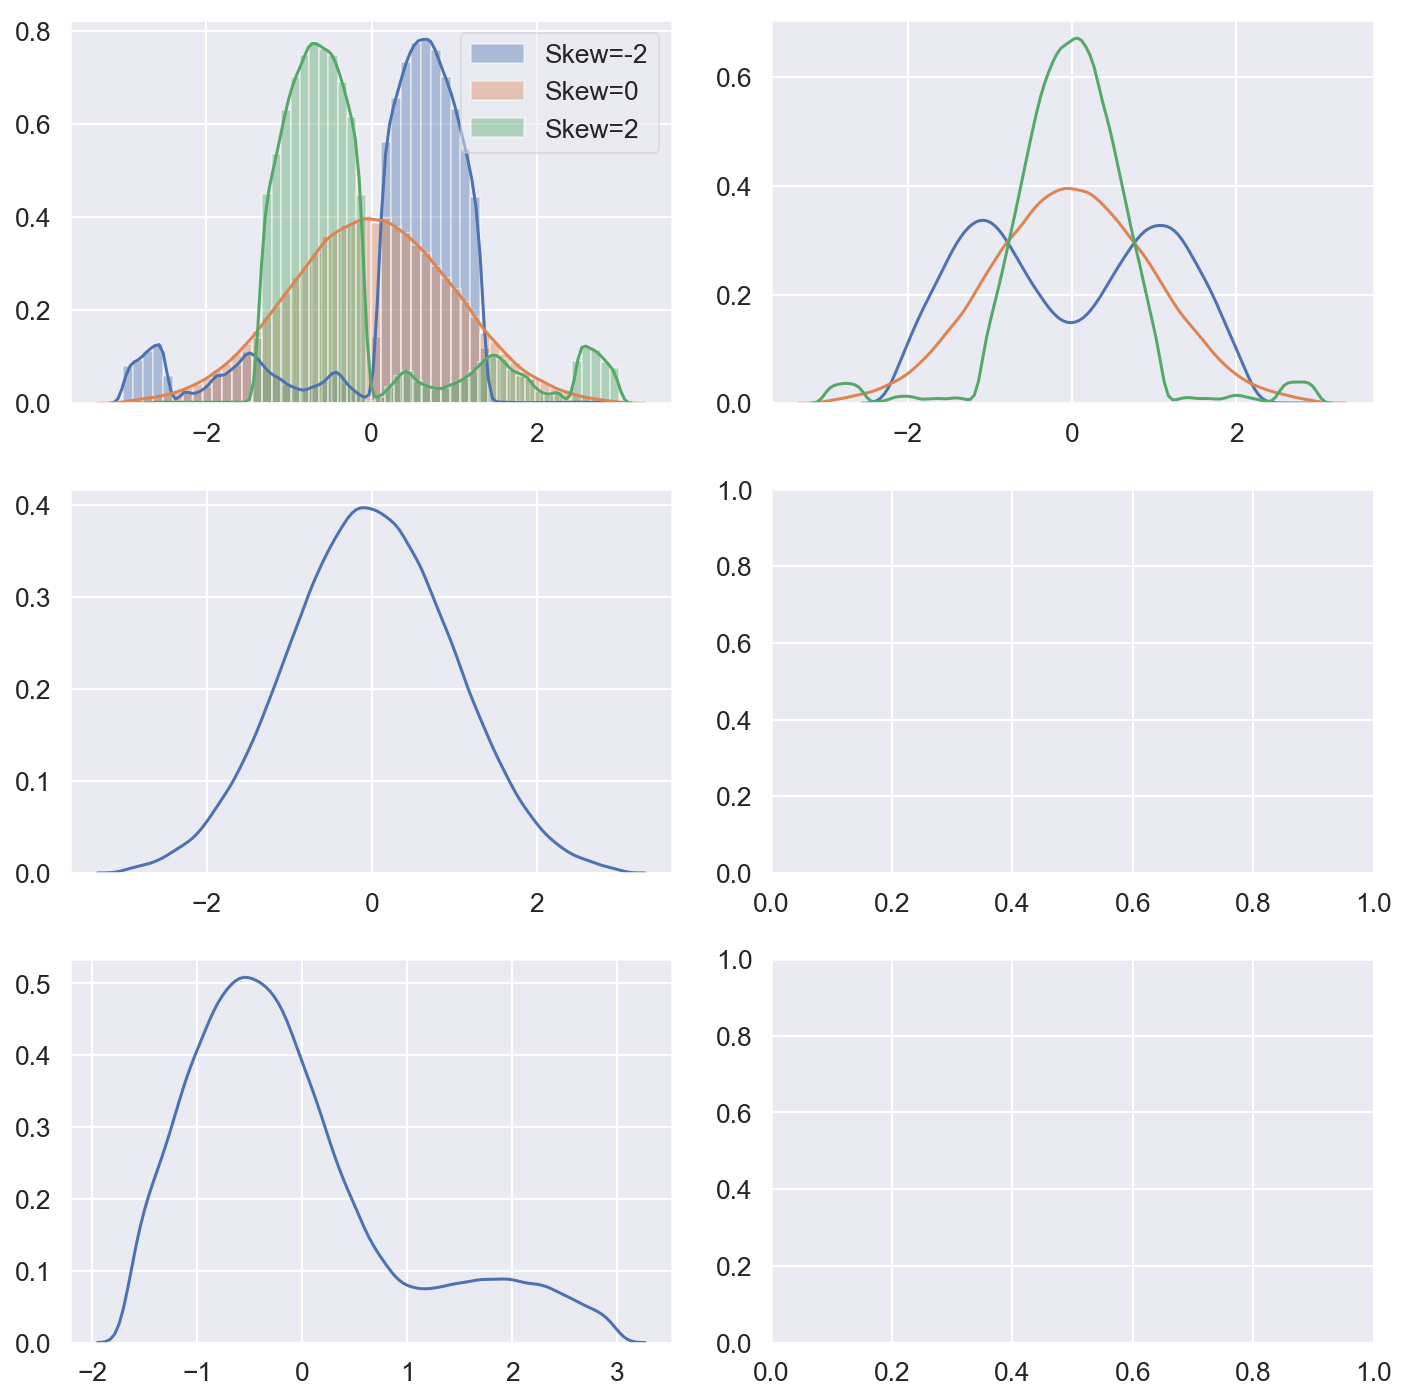

In [87]:
import statsmodels.sandbox.distributions.extras as extras
import scipy.interpolate as interpolate
import numpy as np

def generate_normal_four_moments(mu, sigma, skew, kurt, size=100000, sd_wide = 3):
    f = extras.pdf_mvsk([mu, sigma, skew, kurt])
    x = np.linspace(mu - sd_wide * sigma, mu + sd_wide * sigma, num=500)
    y = [f(i) for i in x]
    yy = np.cumsum(y) / np.sum(y)
    inv_cdf = interpolate.interp1d(yy, x, fill_value="extrapolate")
    rr = np.random.rand(size)
    return inv_cdf(rr)

fig, axes = plt.subplots(3, 2, figsize=(10,10))
sns.distplot(generate_normal_four_moments(0,1,-5,0), hist=True, ax=axes[0,0], label='Skew=-2')
sns.distplot(generate_normal_four_moments(0,1,0,0), hist=True, ax=axes[0,0], label='Skew=0')
sns.distplot(generate_normal_four_moments(0,1,5,0), hist=True, ax=axes[0,0], label='Skew=2')
sns.distplot(generate_normal_four_moments(0,1,0,0), hist=False,  ax=axes[1, 0])
sns.distplot(generate_normal_four_moments(0,1,2,0), hist=False,  ax=axes[2, 0])
sns.distplot(generate_normal_four_moments(0,1,0,-5), hist=False,  ax=axes[0, 1])
sns.distplot(generate_normal_four_moments(0,1,0,0), hist=False,  ax=axes[0, 1])
sns.distplot(generate_normal_four_moments(0,1,0,5), hist=False,  ax=axes[0, 1])
axes[0,0].legend(fancybox=True, framealpha=0.5)
plt.tight_layout()

In [94]:
#from scipy.stats import skewnorm
from statsmodels.sandbox.distributions.extras import pdf_mvsk
q = pdf_mvsk([1,2,1,1])
q

<function statsmodels.sandbox.distributions.extras.pdf_mvsk.<locals>.pdffunc(x)>

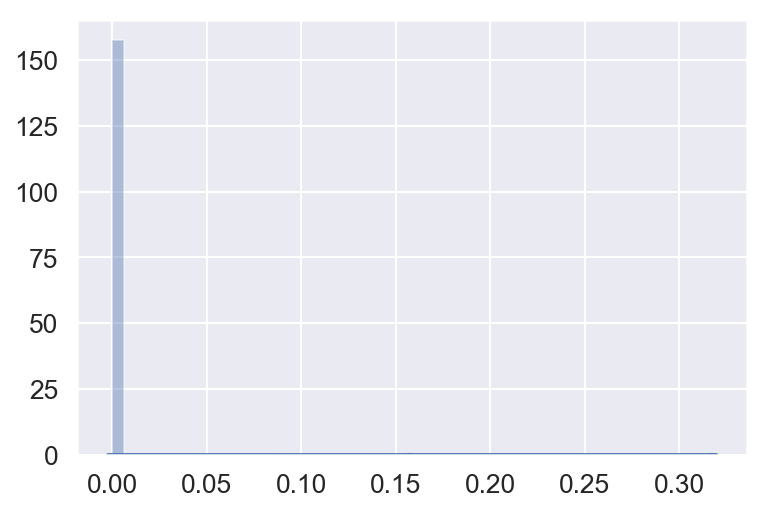

In [95]:
x = np.arange(10000)
y = q(x)
sns.distplot(y)

In [35]:
np.histogram(y)

(array([9996,    1,    0,    1,    0,    0,    0,    1,    0,    1],
       dtype=int64),
 array([0.        , 0.02820948, 0.05641896, 0.08462844, 0.11283792,
        0.1410474 , 0.16925688, 0.19746635, 0.22567583, 0.25388531,
        0.28209479]))

In [ ]:
# Dummy Score (Train): 0.38281574582650235
# Dummy Score (Test): 0.3956553320060741
# rMSE Score (Train): 0.16463060627495957
# rMSE Score (Test): 0.206304463240454
obj.evaluate()

In [ ]:
obj.create_diagnostic_plots()
obj.super_fig

In [15]:
print(obj.all_tests())


=== Linearity Tests ===
	= Rainbow Test =
F-statistic: 1.034342680768431
p-value: 0.4182997166176521

=== Normality Tests ===
	= Shapiro-Wilk Test =
W-statistic: 0.9303425550460815
p-value: 8.490133943106493e-12

	= Anderson-Darling Test =
AD Statistic: 4.239469697613345
Critical Values       : [0.57  0.649 0.778 0.908 1.08 ]
Significance Levels, %: [15.  10.   5.   2.5  1. ]

=== Homoscedasticity Tests ===
	= Breusch-Pagan Test =
Lagrange multiplier statistic: 155.37482760489883
p-value: 8.93322549553354e-17
f-value: 7.585468532455531
f p-value: 1.3900396806844022e-24

	= Goldfeld-Quandt Test =
F statistic: 1.331460813967321
p-value: 0.044022946879221335

=== Multicollinearity Test ===
                      VIF
CHAS__2               inf
CHAS                  inf
CHAS__3               inf
CHAS__05              inf
RAD__2       1.077246e+05
B__2         7.371292e+04
B            6.226949e+04
RAD__3       5.084739e+04
RM           3.823867e+04
RAD          2.205337e+04
RM__2        1.83

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


### Residuals VS Predicted
- If you find equally spread residuals around a horizontal line without distinct patterns, that is a good indication you don’t have non-linear relationships.

- Note that, if the residual plot indicates a non-linear relationship in the data, then a simple approach is to use non-linear transformations of the predictors, such as log(x), sqrt(x) and x^2, in the regression model, Box-Cox transformations

### Scale-Location
- Check that the red line is approximately horizontal. Then the average magnitude of the standardized residuals isn’t changing much as a function of the fitted values.

- Check that the spread around the red line doesn’t vary with the fitted values. Then the variability of magnitudes doesn’t vary much as a function of the fitted values.

**What it will affect:** The predictions will be extremely inaccurate because our model is underfitting. This is a serious violation that should not be ignored.


**Potential solution:**
    
- non-linear transformations to dependent/independent variables

- adding extra features which are a transformation of the already used ones (for example squared version)

- adding features that were not considered before

# Homoscedasticity (equal variance) of residuals

When residuals do not have constant variance (they exhibit heteroscedasticity), it is difficult to determine the true standard deviation of the forecast errors, usually resulting in confidence intervals that are too wide/narrow. For example, if the variance of the residuals is increasing over time, confidence intervals for out-of-sample predictions will be unrealistically narrow. Another effect of heteroscedasticity might also be putting too much weight to a subset of data (thus duplicate records might cause problems) when estimating coefficients — the subset in which the error variance was largest.

This assumes homoscedasticity, which is the same variance within our error terms. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms.

Why it can happen: Our model may be giving too much weight to a subset of the data, particularly where the error variance was the largest.

What it will affect: Significance tests for coefficients due to the standard errors being biased (underestimating p-values). Additionally, the confidence intervals will be either too wide or too narrow.

How to detect it: Plot the residuals and see if the variance appears to be uniform.

How to fix it: Heteroscedasticity can be solved either by using weighted least squares regression instead of the standard OLS or transforming either the dependent or highly skewed variables. Performing a log transformation on the dependent variable is not a bad place to start.

We can also use two statistical tests: Breusch-Pagan and Goldfeld-Quandt. In both of them, the null hypothesis assumes homoscedasticity and a p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.

In [ ]:
resids = obj.model.resid

bp_test = pd.DataFrame(sms.het_breuschpagan(resids, obj.model.model.exog), 
                       columns=['value'],
                       index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, obj.model.model.exog)[:-1],
                       columns=['value'],
                       index=['F statistic', 'p-value'])

print('\n Breusch-Pagan test (Null hypothesis is homoskedasticity)----')
# The tests the hypothesis that the residual variance does not depend on the variables in x in the form
print(bp_test)
print('\n Goldfeld-Quandt test ----')
print(gq_test)

The Goldfeld-Quandt heteroskedasticity test is useful when the regression model to be tested includes an indicator variable among its regressors.

# No Strong Multicollinearity among Predictors

In other words, the features should be linearly independent. What does that mean in practice? We should not be able to use a linear model to accurately predict one feature using another one. Let’s take X1 and X2 as examples of features. It could happen that X1 = 2 + 3 * X2, which violates the assumption.

One scenario to watch out for is the ‘dummy variable trap’ — when we use dummy variables to encode a categorical feature and do not omit the baseline level from the model. This results in a perfect correlation between the dummy variables and the constant term.

Multicollinearity can be present in the model, as long as it is not ‘perfect’. In the former case, the estimates are less efficient but still unbiased. The estimates will be less precise and highly sensitive to particular sets of data.

We can detect multicollinearity using the variance inflation factor (VIF). Without going into too many details, the interpretation of VIF is as follows: the square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. If no features are correlated, then all values for VIF will be 1.


This assumes that the predictors used in the regression are not correlated with each other. This won’t render our model unusable if violated, but it will cause issues with the interpretability of the model.

Why it can happen: A lot of data is just naturally correlated. For example, if trying to predict a house price with square footage, the number of bedrooms, and the number of bathrooms, we can expect to see correlation between those three variables because bedrooms and bathrooms make up a portion of square footage.

What it will affect: Multicollinearity causes issues with the interpretation of the coefficients. Specifically, you can interpret a coefficient as “an increase of 1 in this predictor results in a change of (coefficient) in the response variable, holding all other predictors constant.” This becomes problematic when multicollinearity is present because we can’t hold correlated predictors constant. Additionally, it increases the standard error of the coefficients, which results in them potentially showing as statistically insignificant when they might actually be significant.

How to detect it: There are a few ways, but we will use a heatmap of the correlation as a visual aid and examine the variance inflation factor (VIF).

How to fix it: This can be fixed by other removing predictors with a high variance inflation factor (VIF) or performing dimensionality reduction.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
df = pd.DataFrame({'vif': vif[:-1]}, index=X.columns[:-1])
df = df.sort_values(by='vif', ascending=False)
df

In [ ]:
def vif_color_func(x, orange_threshold = 4, red_threshold = 5):
    if x < 4:
        return "background: lightgreen"
    elif x >= 4 and x < 5:
        return "background: orange"
    elif x >= 5:
        return "background: red"

In [ ]:
df = df.sort_values(by='vif', ascending=False)
df = df[['vif']].style.apply(lambda x: [vif_color_func(v) for v in x], axis = 0)

In [ ]:
df

Remove features with high VIF values or try PCA

# Normality of the error terms

More specifically, this assumes that the error terms of the model are normally distributed. Linear regressions other than Ordinary Least Squares (OLS) may also assume normality of the predictors or the label, but that is not the case here.

Why it can happen: This can actually happen if either the predictors or the label are significantly non-normal. Other potential reasons could include the linearity assumption being violated or outliers affecting our model.

What it will affect: A violation of this assumption could cause issues with either shrinking or inflating our confidence intervals.

How to detect it: There are a variety of ways to do so, but we’ll look at both a histogram and the p-value from the Anderson-Darling test for normality.

How to fix it: It depends on the root cause, but there are a few options. Nonlinear transformations of the variables, excluding specific variables (such as long-tailed variables), or removing outliers may solve this problem.

In [ ]:
# from scipy.stats import norm
# my_data = norm.rvs(size=1000)
def qq():
    sns.mpl.rcParams['figure.figsize'] = (8.0, 8.0)
    sns.set(font_scale=1.5)
    #fig, ax = plt.subplots();
    ax = super_fig.add_subplot(122)
    sm.qqplot(resids, line='s', ax=ax);
    ax.set_title('QQ-Plot', fontsize=16)
    ax.grid(b=True, which='major', color='k', linewidth=1.0, alpha=0.3);
    #plt.close(fig)
    return ax
a2 = qq()

In [ ]:
super_fig

In [ ]:
all_axes = super_fig.get_axes()
all_axes

In [ ]:
all_axes[0].get_figure()

In [ ]:
from scipy.stats import shapiro, anderson
_, p = shapiro(resids)
p

In [ ]:
shapiro(resids)

if > 0.05 -> ~ normal

In [ ]:
q = anderson(resids, dist='norm')
q

In [ ]:
list(q)

In [ ]:
q.

In [ ]:
from scipy.stats import norm
my_data = norm.rvs(size=1000)
anderson(my_data, dist='norm')

The Anderson-Darling tests the null hypothesis that a sample is drawn from a population that follows a particular distribution.

The null hypothesis is rejected at a particular significance level if a test statistic is higher than all the corresponding critical value.

# Scale Location Plot

In the example which you show the two plots, the residuals versus fitted and the scale versus location clearly give the same message. The scale location plot however is superior when the points are rather unevenly distributed along the x
x-axis. In that case it can be hard to distinguish in the residual versus fitted whether the apparent increase in spread is because there are more points in that part of the space or because there is a genuine increase.